In [1]:
# Libs
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)

In [2]:
class MyImageFolder(datasets.ImageFolder):  
    def __init__(self, root, transform=None, target_transform=None,  
                 loader=datasets.folder.default_loader,  
                 is_valid_file=None,):  
        super(MyImageFolder, self).__init__(root, transform, target_transform, loader, is_valid_file)  

    def __getitem__(self, index): 
        path, _ = self.samples[index] 
        sample, _ = super(MyImageFolder, self).__getitem__(index) 
        return sample, path[-16:]

In [3]:
# Load data
torch.manual_seed(42)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_transform_gpu = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
train_ds = MyImageFolder('./task_images_downsampled/train',
                                transform = train_transform,)
batch_size=64
def get_dataloader_workers():
    return 4
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,)

00016410_004.png


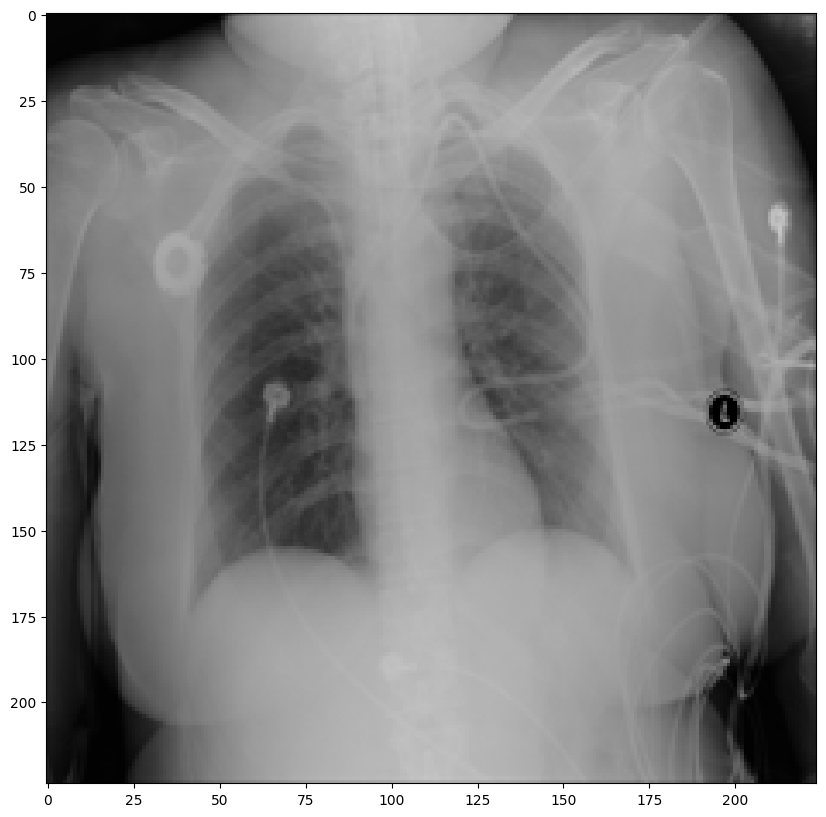

In [5]:
def displayImg(img):
    npImg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()

someImages = None
someNames = None
i=0
for X,name in train_dl:
    someImages=X
    someNames = name
    break

for i in range(1,2):
    print(someNames[i])
    displayImg(someImages[i])

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model=resnet18(num_classes = 2).to(device)
model.load_state_dict(torch.load('best.pkl'))
model.eval() # there is a strange bug that the model always predict 3 in following evaluation without this

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
def interprete(model,input_tensor,targets,path):
    target_layers = [model.layer4[-1]]
    cam_algorithm = GradCAM
    with cam_algorithm(model=model,
                        target_layers=target_layers) as cam:
        cam.batch_size = 32

        grayscale_cam = torch.tensor(cam(input_tensor=input_tensor, 
                            targets=targets,
                            )).to(device)
        
        grayscale_cam = grayscale_cam[0, :]
        indices8 = grayscale_cam > 0.8
        indices6 = grayscale_cam > 0.6
        indices4 = grayscale_cam > 0.4
        indices2 = grayscale_cam > 0.2
        grayscale_cam[:,:] = 1
        grayscale_cam[indices2] = 0.8
        grayscale_cam[indices4] = 0.6
        grayscale_cam[indices6] = 0.4
        grayscale_cam[indices8] = 0.2
        grayscale_cam = (grayscale_cam.cpu().numpy()*255).astype(np.uint8)
        cv2.imwrite(path,grayscale_cam)

for X,name in tqdm(train_dl):
    X = X.to(device)
    for j in range(len(X)):
        #targets = [ClassifierOutputTarget(model(X[j]))]
        targets = None
        input_tensor = train_transform_gpu(X[j:j+1]).to(device)
        interprete(model,input_tensor,targets,"./heatmaps/"+name[j])

100%|██████████| 964/964 [17:16<00:00,  1.08s/it]
